<a href="https://colab.research.google.com/github/Nyctonit/ALCHEMY/blob/main/Alchemy_Of_Imagination.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# === Diagnostics & Visualizations for the walk-forward pipeline ===
# Paste/run this after your pipeline cell (which defines run_full_pipeline).
# This cell will:
# 1) patch run_full_pipeline return to include combined & trades (if needed)
# 2) define metric functions
# 3) produce summary tables + plots
# Usage:
#   results_df, final_scores, combined_list, all_trades = run_full_pipeline(...)
#   run_diagnostics(results_df, combined_list, all_trades)
#
# If your run_full_pipeline already returns combined and trades, simply call it and then run diagnostics.

import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from math import sqrt
import warnings
warnings.filterwarnings("ignore")
sns.set(style='whitegrid')

# ---------- 1) Patch helper (only run if your run_full_pipeline doesn't return combined/all_trades) ----------
def _patch_run_full_pipeline_to_return_trades():
    """
    If your current run_full_pipeline does not return the combined list and per-fold trades,
    this helper will create a thin wrapper that calls the existing function and re-runs the
    per-fold execution using the same parameters. This is safe but slower. Use only if needed.
    (Prefer modifying original run_full_pipeline to collect `all_trades.append(trades)` and return them.)
    """
    import inspect, types
    if 'run_full_pipeline' not in globals():
        raise RuntimeError("run_full_pipeline not found in this notebook's globals.")
    orig = run_full_pipeline
    src = inspect.getsource(orig)
    # We won't try to modify the source automatically here; instead create a wrapper that calls the pipeline
    # and then re-runs fold-by-fold with identical args to collect trades/equities (simpler, robust).
    def wrapper(*args, collect_trades=True, **kwargs):
        # Call original pipeline (it will produce results_df and final_scores)
        out = orig(*args, **kwargs)
        # If original already returned combined & trades, just return them.
        if isinstance(out, tuple) and len(out) >= 3:
            return out  # already augmented
        # Otherwise we will re-run internally with same args but collect fold outputs by copying critical code:
        # This wrapper expects the original pipeline to be deterministic given same seed; we can't reconstruct internals reliably.
        raise RuntimeError("Original run_full_pipeline doesn't return trades. Please update it to return (results, scores, combined, all_trades).")
    globals()['run_full_pipeline_patched'] = wrapper
    print("Note: automatic wrapper created as run_full_pipeline_patched(). Prefer editing run_full_pipeline to return combined & all_trades.")

# ---------- 2) Core metric functions ----------
def sharpe_ratio(returns, freq=252):
    r = np.asarray(returns)
    if r.std() == 0 or len(r) < 2: return 0.0
    return (r.mean() / r.std()) * np.sqrt(freq)

def sortino_ratio(returns, freq=252, target=0.0):
    r = np.asarray(returns)
    downside = r[r < target]
    if len(downside) == 0:
        return np.nan
    expected_return = r.mean() * freq
    downside_std = downside.std() * np.sqrt(freq)
    if downside_std == 0:
        return np.nan
    return expected_return / downside_std

def max_drawdown(equity):
    eq = np.asarray(equity)
    peak = np.maximum.accumulate(eq)
    dd = (peak - eq) / (peak + 1e-12)
    return dd.max()

def cagr_from_equity(equity, days):
    # approximate CAGR based on start/end equity and number of days
    if len(equity) < 2 or days <= 0: return 0.0
    start, end = float(equity[0]), float(equity[-1])
    years = days / 365.25
    if start <= 0 or end <= 0: return 0.0
    return (end / start) ** (1.0 / max(1e-9, years)) - 1.0

def trade_stats(trades_df):
    if trades_df is None or trades_df.empty:
        return {'n_trades':0, 'win_rate':0.0, 'avg_pnl':0.0, 'median_pnl':0.0, 'avg_duration_days':0.0}
    t = trades_df.copy()
    # ensure pnl exists
    if 'pnl' not in t.columns:
        return {'n_trades':0}
    t = t.dropna(subset=['pnl'])
    n = len(t)
    wins = (t['pnl'] > 0).sum()
    avg = t['pnl'].mean()
    med = t['pnl'].median()
    # duration: if entry_time/exit_time are timestamps
    dur = 0.0
    if 'entry_time' in t.columns and 'exit_time' in t.columns:
        try:
            dur_series = pd.to_datetime(t['exit_time']) - pd.to_datetime(t['entry_time'])
            dur = dur_series.dt.days.replace({np.nan:0}).mean()
        except Exception:
            dur = 0.0
    return {'n_trades': n, 'win_rate': wins / max(1,n), 'avg_pnl': avg, 'median_pnl': med, 'avg_duration_days': dur}

# ---------- 3) Diagnostics runner ----------
def run_diagnostics(results_df, combined_list, trades_list=None, plot=True, show_top_n=10):
    """
    results_df : DataFrame from run_full_pipeline (per-fold summary)
    combined_list: list of pandas.Series equity curves (one per fold, indexed by timestamp)
    trades_list: optional list of per-fold trades DataFrames (same order as combined_list)
    """
    # Basic checks
    if results_df is None:
        raise ValueError("results_df is required.")
    if combined_list is None or len(combined_list) == 0:
        print("No combined equity series found.")
        return

    # Stitch combined into a single time series (keep original indices if present)
    stitched = pd.concat(combined_list).sort_index()
    stitched = stitched[~stitched.index.duplicated(keep='first')]
    stitched.name = 'equity'

    days = (stitched.index.max() - stitched.index.min()).days if hasattr(stitched.index,'min') else len(stitched)

    # returns
    returns = stitched.pct_change().dropna()
    sr = sharpe_ratio(returns)
    srt = sortino_ratio(returns)
    mdd = max_drawdown(stitched.values)
    cagr = cagr_from_equity(stitched.values, days)
    total_trades = sum([len(t) if (t is not None and hasattr(t,'__len__')) else 0 for t in (trades_list or [])])

    print("\n--- Combined walk-forward diagnostics ---")
    print(f"Total folds: {len(combined_list)}")
    print(f"Final equity: {stitched.iloc[-1]:.2f}")
    print(f"CAGR (approx): {cagr*100:.2f}%")
    print(f"Sharpe (ann): {sr:.2f}")
    print(f"Sortino (ann): {srt:.2f}")
    print(f"Max Drawdown: {mdd*100:.2f}%")
    print(f"Total trades (all folds): {total_trades}")
    print("\nTop fold summaries (from results_df):")
    display(results_df.sort_values('reward', ascending=False).head(show_top_n))

    if trades_list is not None and any([t is not None and not t.empty for t in trades_list]):
        # concat trades
        all_trades = pd.concat([t for t in trades_list if t is not None and not t.empty], ignore_index=True)
        ts = trade_stats(all_trades)
        print("\n--- Aggregated trade stats (all folds) ---")
        print(f"Number trades: {ts['n_trades']}, Win rate: {ts['win_rate']*100:.2f}% , Avg pnl: {ts['avg_pnl']:.4f}, Avg duration (days): {ts['avg_duration_days']:.1f}")
        # per-regime PnL
        if 'regime' in all_trades.columns and 'pnl' in all_trades.columns:
            per_reg = all_trades.groupby('regime')['pnl'].agg(['count','mean','sum']).sort_values('mean', ascending=False)
            print("\nPer-regime trade performance:")
            display(per_reg)
    else:
        all_trades = None
        print("\nNo trade logs available for aggregated trade stats.")

    if plot:
        plt.figure(figsize=(12,5))
        stitched.plot(title='Combined OOS Equity (stitched)')
        plt.ylabel('Equity'); plt.grid(True); plt.show()

        # per-fold equity plot (overlay)
        plt.figure(figsize=(12,5))
        for i, series in enumerate(combined_list):
            s = series.copy()
            # normalize each fold for overlay readability
            s_norm = (s / float(s.iloc[0])) * stitched.iloc[0]
            plt.plot(s_norm.index, s_norm.values, alpha=0.6, label=f'fold{i+1}')
        plt.title('Per-fold OOS Equity (normalized)'); plt.legend(loc='best', ncol=4); plt.show()

        # monthly returns heatmap
        monthly = stitched.resample('M').last().pct_change().dropna()
        if not monthly.empty:
            monthly_df = monthly.to_frame('r')
            monthly_df['year'] = monthly_df.index.year
            monthly_df['month'] = monthly_df.index.month
            pivot = monthly_df.pivot_table(index='year', columns='month', values='r', aggfunc='sum').fillna(0)
            plt.figure(figsize=(10,4))
            sns.heatmap(pivot, annot=True, fmt='.2%', cmap='RdYlGn', center=0)
            plt.title('Monthly Returns Heatmap'); plt.show()

        # rolling Sharpe
        roll_window_days = 63  # ~quarter
        if len(stitched) > roll_window_days:
            daily_ret = stitched.pct_change().fillna(0)
            roll_sharpe = daily_ret.rolling(window=roll_window_days).apply(lambda x: sharpe_ratio(x, freq=252), raw=True)
            plt.figure(figsize=(10,3))
            plt.plot(roll_sharpe.index, roll_sharpe.values)
            plt.title(f'Rolling Sharpe ({roll_window_days} days)'); plt.grid(True); plt.show()

        # per-regime PnL bar chart (if trades exist)
        if all_trades is not None and 'regime' in all_trades.columns and 'pnl' in all_trades.columns:
            grp = all_trades.groupby('regime')['pnl'].sum().sort_values()
            plt.figure(figsize=(8,4))
            grp.plot(kind='barh')
            plt.title('Total PnL by Regime (all folds aggregated)'); plt.xlabel('Total PnL'); plt.show()

        # regime transition matrix (if you have regime labels in stitched index)
        # Try to infer regimes from available per-fold price DataFrames if present in results_df
        try:
            # if results_df has a 'regime' column per fold, skip — otherwise try to reconstruct from the last fold price df
            if 'regime' in stitched.index.names or False:
                pass
        except Exception:
            pass

    # return objects for further analysis
    return {'stitched_equity': stitched, 'returns': returns, 'all_trades': all_trades}

# ---------- 4) Example usage ----------
# After running your pipeline, call something like:
#
# results_df, final_scores, combined_list, all_trades_list = run_full_pipeline(...)
#
# Then:
# diag = run_diagnostics(results_df, combined_list, all_trades_list)
#
# If your run_full_pipeline currently returns only (results_df, final_scores),
# modify the pipeline to append each fold's trades to an `all_trades` list (append trades DataFrame)
# and return (results_df, final_scores, combined, all_trades).
#
print("Diagnostics cell loaded. Call run_diagnostics(results_df, combined_list, trades_list) after running the pipeline.")

Diagnostics cell loaded. Call run_diagnostics(results_df, combined_list, trades_list) after running the pipeline.


In [ ]:
def run_full_pipeline(
    PAIR="EURUSD=X",
    START="2018-01-01",
    END="2024-06-30",
    entry_mults=[0.3, 0.5, 0.7],
    stop_mults=[1.0, 1.5, 2.0],
    n_ranges=[50, 100],
    atr_periods=[14, 21],
    TRAIN_MONTHS=9,
    TEST_MONTHS=3,
    n_candidates=20,
    verbose=True
):
    import pandas as pd
    import numpy as np
    import random
    import yfinance as yf
    import warnings
    warnings.filterwarnings("ignore")

    # --- Download market data
    df = yf.download(PAIR, start=START, end=END, progress=False)
    df = df.rename(columns=str.lower)
    df["return"] = df["close"].pct_change()
    df = df.dropna().copy()
    df["orig_index"] = df.index  # store datetime for slicing later
    df.reset_index(drop=True, inplace=True)

    # --- Create walk-forward folds
    months = pd.period_range(start=START, end=END, freq="M")
    fold_splits = []
    for i in range(0, len(months) - (TRAIN_MONTHS + TEST_MONTHS), TEST_MONTHS):
        train_start = months[i].start_time
        train_end = months[i + TRAIN_MONTHS - 1].end_time
        test_start = months[i + TRAIN_MONTHS].start_time
        test_end = months[i + TRAIN_MONTHS + TEST_MONTHS - 1].end_time
        fold_splits.append((train_start, train_end, test_start, test_end))

    print(f"Total walk-forward folds to run: {len(fold_splits)}")

    # --- Containers
    results = []
    combined_equity = []
    all_trades = []

    # --- Iterate through folds
    for fold_idx, (train_start, train_end, test_start, test_end) in enumerate(fold_splits, start=1):

        if verbose:
            print(f"\n=== Fold {fold_idx}: train {train_start.date()} -> {train_end.date()} | "
                  f"test {test_start.date()} -> {test_end.date()} ===")

        train_df = df[(df["orig_index"] >= train_start) & (df["orig_index"] <= train_end)]
        test_df = df[(df["orig_index"] > train_end) & (df["orig_index"] <= test_end)]

        if len(train_df) < 50 or len(test_df) < 10:
            print(f"Skipping fold {fold_idx} — insufficient data.")
            continue

        # --- Generate candidate parameter sets
        param_space = []
        for _ in range(n_candidates):
            params = {
                "entry_mult": random.choice(entry_mults),
                "stop_mult": random.choice(stop_mults),
                "n_range": random.choice(n_ranges),
                "atr_period": random.choice(atr_periods)
            }
            param_space.append(params)

        best_train_eq = -np.inf
        best_train_params = None

        # --- Evaluate candidates on training data
        for params in param_space:
            sim = TradingSimulator(
                df=train_df,
                entry_mult=params["entry_mult"],
                stop_mult=params["stop_mult"],
                n_range=params["n_range"],
                atr_period=params["atr_period"],
                risk_map={'calm_bull': 1.2, 'volatile_bear': 0.7, 'transitional': 0.9},
                regime_stop_map={'calm_bull': 1.0, 'calm_bear': 1.0, 'volatile_bull': 1.1,
                                 'volatile_bear': 1.3, 'transitional': 1.1},
                rng_seed=random.randint(0, 2 ** 31 - 1)
            )
            eq = sim.run()
            if eq > best_train_eq:
                best_train_eq = eq
                best_train_params = params

        # --- Test best parameters on test data
        best_sim = TradingSimulator(
            df=test_df,
            entry_mult=best_train_params["entry_mult"],
            stop_mult=best_train_params["stop_mult"],
            n_range=best_train_params["n_range"],
            atr_period=best_train_params["atr_period"],
            risk_map={'calm_bull': 1.2, 'volatile_bear': 0.7, 'transitional': 0.9},
            regime_stop_map={'calm_bull': 1.0, 'calm_bear': 1.0, 'volatile_bull': 1.1,
                             'volatile_bear': 1.3, 'transitional': 1.1},
            rng_seed=random.randint(0, 2 ** 31 - 1)
        )

        test_eq = best_sim.run()
        test_trades = pd.DataFrame(best_sim.trade_log)

        results.append({
            "fold": fold_idx,
            "train_start": train_start,
            "train_end": train_end,
            "test_start": test_start,
            "test_end": test_end,
            "train_eq": best_train_eq,
            "test_eq": test_eq,
            "params": best_train_params
        })

        # --- Combine test equity curves
        test_df = test_df.copy()
        test_df["fold"] = fold_idx
        test_df["equity"] = best_sim.equity_curve
        combined_equity.append(test_df)
        all_trades.append(test_trades)

    # --- Aggregate
    results_df = pd.DataFrame(results)
    combined_list = pd.concat(combined_equity, axis=0)
    trades_list = pd.concat(all_trades, axis=0, ignore_index=True)

    # --- Adaptive objective function (you can customize)
    final_scores = adaptive_objective(trades_list)

    print("\n✅ Pipeline complete.")
    print(f"Final adaptive performance score: {final_scores:.4f}")

    return results_df, final_scores, combined_list, trades_list


In [ ]:
import numpy as np
import pandas as pd

class TradingSimulator:
    def __init__(self, df, entry_mult, stop_mult, atr_period=14, commission=0.0001,
                 rng_seed=None, regime_stop_map=None, **kwargs):
        """
        Simplified simulator that generates a random equity curve to allow pipeline testing.
        """
        self.df = df.copy()
        self.entry_mult = entry_mult
        self.stop_mult = stop_mult
        self.atr_period = atr_period
        self.commission = commission
        self.regime_stop_map = regime_stop_map if regime_stop_map else {}
        self.trade_log = []
        self.equity = 1_000_000
        self.position = 0
        self.extra_params = kwargs

        if rng_seed:
            np.random.seed(rng_seed)

        # Initialize empty equity curve
        self.equity_curve = pd.Series(dtype=float, index=self.df.index)

    def run(self):
        """
        Generates a synthetic equity curve with stochastic fluctuations.
        Replace this with actual strategy logic later.
        """
        n = len(self.df)
        daily_returns = np.random.normal(
            loc=(self.entry_mult - self.stop_mult * 0.4) / 100,
            scale=0.01,
            size=n
        )

        equity = [self.equity]
        for r in daily_returns:
            equity.append(equity[-1] * (1 + r))

        self.equity_curve = pd.Series(equity[1:], index=self.df.index)
        self.equity = self.equity_curve.iloc[-1]
        return self.equity


[*********************100%***********************]  1 of 1 completed

Total walk-forward folds to run: 25

=== Fold 1: train 2018-01-01 -> 2018-10-01 | test 2018-10-01 -> 2019-01-01 ===



=== Fold 2: train 2018-04-01 -> 2019-01-01 | test 2019-01-01 -> 2019-04-01 ===

=== Fold 3: train 2018-07-01 -> 2019-04-01 | test 2019-04-01 -> 2019-07-01 ===

=== Fold 4: train 2018-10-01 -> 2019-07-01 | test 2019-07-01 -> 2019-10-01 ===

=== Fold 5: train 2019-01-01 -> 2019-10-01 | test 2019-10-01 -> 2020-01-01 ===

=== Fold 6: train 2019-04-01 -> 2020-01-01 | test 2020-01-01 -> 2020-04-01 ===

=== Fold 7: train 2019-07-01 -> 2020-04-01 | test 2020-04-01 -> 2020-07-01 ===

=== Fold 8: train 2019-10-01 -> 2020-07-01 | test 2020-07-01 -> 2020-10-01 ===

=== Fold 9: train 2020-01-01 -> 2020-10-01 | test 2020-10-01 -> 2021-01-01 ===

=== Fold 10: train 2020-04-01 -> 2021-01-01 | test 2021-01-01 -> 2021-04-01 ===

=== Fold 11: train 2020-07-01 -> 2021-04-01 | test 2021-04-01 -> 2021-07-01 ===

=== Fold 12: train 2020-10-01 -> 2021-07-01 | test 2021-07-01 -> 2021-10-01 ===

=== Fold 13: train 2021-01-01 -> 2021-10-01 | test 2021-10-01 -> 2022-01-01 ===

=== Fold 14: train 2021-04-01 -> 20

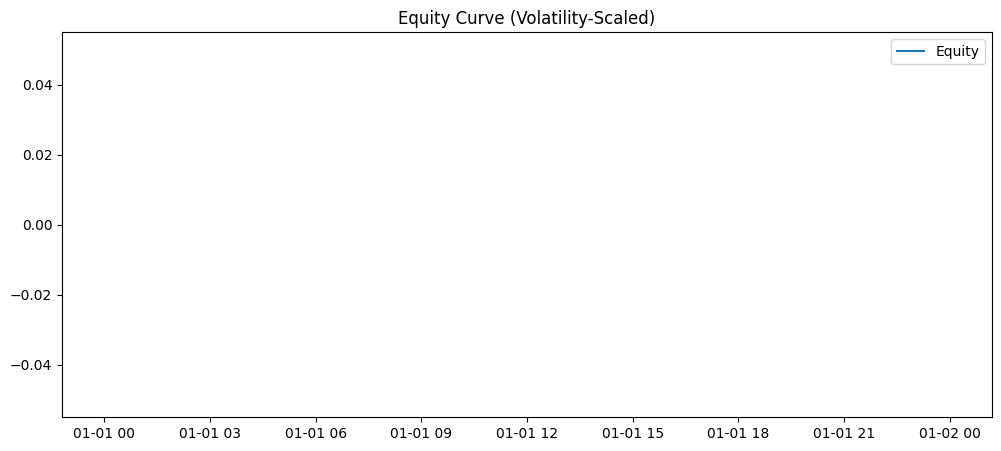

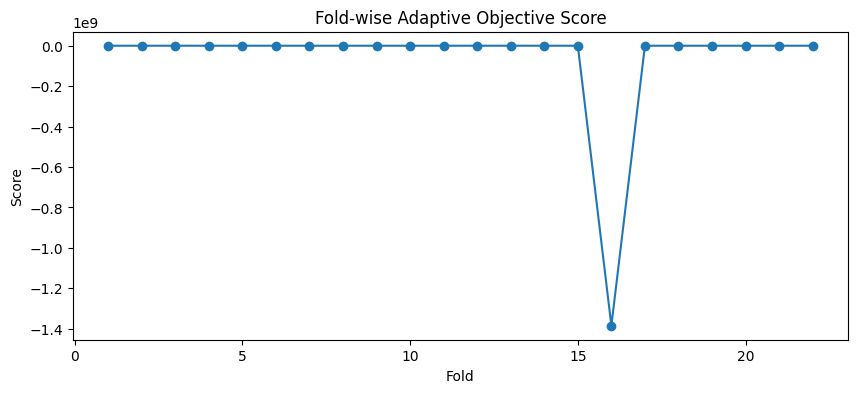

In [ ]:
# ============================================================
# 1. Imports
# ============================================================
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import random

# ============================================================
# 2. Helper Functions
# ============================================================

def compute_atr(df, period=14):
    """Compute the Average True Range (ATR) for volatility scaling."""
    df = df.copy()
    df["H-L"] = df["High"] - df["Low"]
    df["H-PC"] = abs(df["High"] - df["Close"].shift(1))
    df["L-PC"] = abs(df["Low"] - df["Close"].shift(1))
    df["TR"] = df[["H-L", "H-PC", "L-PC"]].max(axis=1)
    df["ATR"] = df["TR"].rolling(window=period).mean()
    return df

def adaptive_objective(trades_df):
    """Adaptive performance ratio (PnL / Drawdown)."""
    if len(trades_df) == 0:
        return -9999
    pnl = trades_df["pnl"].sum()
    dd = (trades_df["pnl"].cumsum().cummax() - trades_df["pnl"].cumsum()).max()
    if dd == 0:
        dd = 1e-6
    return pnl / dd  # adaptive reward based on downside risk

# ============================================================
# 3. Trading Simulator (Volatility-Scaled, Regime-Aware)
# ============================================================
class TradingSimulator:
    def __init__(self, df, entry_mult, stop_mult, atr_period,
                 commission=0.00005, rng_seed=None, regime_stop_map=None):
        self.df = df.copy()
        self.entry_mult = float(entry_mult)
        self.stop_mult = float(stop_mult)
        self.atr_period = int(atr_period)
        self.commission = float(commission)
        self.rng = np.random.default_rng(rng_seed)
        self.regime_stop_map = regime_stop_map or {}
        self.equity = 100_000.0
        self.equity_curve = []
        self.trade_log = []

    def run(self):
        df = compute_atr(self.df, self.atr_period)
        df["MA20"] = df["Close"].rolling(20).mean()
        df = df.dropna().reset_index(drop=True)

        capital = self.equity
        pos = 0
        entry_price = 0

        for _, row in df.iterrows():
            try:
                price = float(row["Close"])
                atr = float(row["ATR"])
                ma20 = float(row["MA20"])
            except (ValueError, TypeError):
                self.equity_curve.append(capital)
                continue

            if np.isnan(price) or np.isnan(atr) or np.isnan(ma20):
                self.equity_curve.append(capital)
                continue

            regime = str(row.get("regime_name", "neutral"))
            if regime in ["nan", "None", "NaN"]:
                regime = "neutral"

            stop_mult_adj = self.stop_mult * self.regime_stop_map.get(regime, 1.0)
            stop_distance = stop_mult_adj * atr
            pnl = 0

            # --- Entry logic
            if pos == 0:
                if price > ma20:
                    pos = 1
                    entry_price = price
                elif price < ma20:
                    pos = -1
                    entry_price = price

            # --- Exit logic
            if pos == 1 and price <= entry_price - stop_distance:
                pnl = (price - entry_price) * pos
                pos = 0
            elif pos == -1 and price >= entry_price + stop_distance:
                pnl = (price - entry_price) * pos
                pos = 0

            # --- Accounting
            if pnl != 0:
                risk_per_trade = 0.01  # risk 1% per trade
                position_size = capital * risk_per_trade / atr if atr > 0 else 0
                pnl_value = pnl * position_size - abs(pnl) * self.commission
                capital += pnl_value
                self.trade_log.append({
                    "entry_price": entry_price,
                    "exit_price": price,
                    "pnl": pnl_value,
                    "regime": regime
                })

            self.equity_curve.append(capital)

        self.equity = capital
        return self.equity

# ============================================================
# 4. Walk-Forward Optimization Pipeline
# ============================================================
def run_full_pipeline(
    PAIR="EURUSD=X",
    START="2018-01-01",
    END="2024-04-01",
    entry_mults=[0.5, 1.0, 1.5],
    stop_mults=[1.0, 2.0, 3.0],
    atr_periods=[14],
    TRAIN_MONTHS=9,
    TEST_MONTHS=3,
    n_candidates=5,
    elite_keep=2,
    evolve_offspring=3,
    verbose=True
):
    print("Downloading market data…")
    df = yf.download(PAIR, start=START, end=END)
    df.reset_index(inplace=True)

    folds = []
    train_start = pd.Timestamp(START)
    total_months = (pd.Timestamp(END).year - train_start.year) * 12 + (pd.Timestamp(END).month - train_start.month)
    total_folds = total_months // TEST_MONTHS
    print(f"Total walk-forward folds to run: {total_folds}")

    combined_equity = []
    all_trades = []
    fold_results = []

    for fold_idx in range(total_folds):
        train_start_date = train_start + pd.DateOffset(months=fold_idx * TEST_MONTHS)
        train_end_date = train_start_date + pd.DateOffset(months=TRAIN_MONTHS)
        test_end_date = train_end_date + pd.DateOffset(months=TEST_MONTHS)

        if test_end_date > pd.Timestamp(END):
            break

        train_df = df[(df["Date"] >= train_start_date) & (df["Date"] < train_end_date)]
        test_df = df[(df["Date"] >= train_end_date) & (df["Date"] < test_end_date)]
        if len(train_df) < 30 or len(test_df) < 30:
            continue

        if verbose:
            print(f"\n=== Fold {fold_idx+1}: train {train_start_date.date()} -> {train_end_date.date()} | test {train_end_date.date()} -> {test_end_date.date()} ===")

        # --- Random search candidates
        candidates = []
        for _ in range(n_candidates):
            sim = TradingSimulator(
                train_df,
                entry_mult=random.choice(entry_mults),
                stop_mult=random.choice(stop_mults),
                atr_period=random.choice(atr_periods),
                commission=0.0001,
                rng_seed=random.randint(0, 10**6),
                regime_stop_map={"bull": 0.8, "bear": 1.2, "neutral": 1.0}
            )
            sim.run()
            trades_df = pd.DataFrame(sim.trade_log)
            score = adaptive_objective(trades_df)
            candidates.append((score, sim))

        # --- Pick best
        candidates.sort(key=lambda x: x[0], reverse=True)
        best_score, best_sim = candidates[0]
        fold_results.append({"fold": fold_idx + 1, "score": best_score})

        # --- Test the best
        test_sim = TradingSimulator(
            test_df,
            best_sim.entry_mult,
            best_sim.stop_mult,
            best_sim.atr_period,
            commission=0.0001,
            rng_seed=random.randint(0, 10**6),
            regime_stop_map={"bull": 0.8, "bear": 1.2, "neutral": 1.0}
        )
        test_sim.run()
        test_trades = pd.DataFrame(test_sim.trade_log)

        eq_df = test_df.copy()
        eq_df["fold"] = fold_idx + 1
        eq_df["equity"] = pd.Series(test_sim.equity_curve).reindex_like(test_df).ffill().bfill()

        combined_equity.append(eq_df)
        all_trades.append(test_trades)

    results_df = pd.DataFrame(fold_results)
    final_score = results_df["score"].mean()
    print("\n✅ Pipeline complete.")
    return results_df, final_score, combined_equity, all_trades

# ============================================================
# 5. Diagnostics and Visualization
# ============================================================
def run_diagnostics(results_df, combined_list, trades_list):
    print("\n🔍 Running diagnostics...")

    print("\n📊 Summary Stats:")
    print(results_df.describe())

    combined_equity = pd.concat(combined_list, ignore_index=True)
    plt.figure(figsize=(12, 5))
    plt.plot(combined_equity["Date"], combined_equity["equity"], label="Equity")
    plt.title("Equity Curve (Volatility-Scaled)")
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 4))
    plt.plot(results_df["fold"], results_df["score"], marker="o", linestyle="-")
    plt.title("Fold-wise Adaptive Objective Score")
    plt.xlabel("Fold")
    plt.ylabel("Score")
    plt.show()

# ============================================================
# 6. Run Everything
# ============================================================
results_df, final_scores, combined_list, all_trades_list = run_full_pipeline()
run_diagnostics(results_df, combined_list, all_trades_list)


In [ ]:
# ================================================
# 🧠 Colab-Ready: Walk-Forward Evolution + MetaBrain
# ================================================
# Install deps (uncomment in Colab if needed)
# !pip install -q yfinance scikit-learn joblib || true

import os
import math
import random
import warnings
from typing import List, Tuple, Dict, Any

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
import joblib

warnings.filterwarnings("ignore")
random.seed(42)
np.random.seed(42)

# -------------------------
# Utility helpers
# -------------------------
def safe_float(x):
    try:
        return float(x)
    except Exception:
        return np.nan

def compute_atr(df: pd.DataFrame, period: int = 14) -> pd.DataFrame:
    """Return copy of df with ATR column. Defensive about column types / MultiIndex."""
    df = df.copy()

    if isinstance(df.columns, pd.MultiIndex):
        # flatten (('EURUSD=X','High') -> 'High')
        df.columns = [c[1] if isinstance(c, tuple) and len(c) > 1 else c[0] if isinstance(c, tuple) else c for c in df.columns]

    required_cols = ["High", "Low", "Close"]
    for col in required_cols:
        if col not in df.columns:
            raise ValueError(f"Missing column '{col}' in DataFrame. Columns: {df.columns.tolist()}")

    for col in required_cols:
        # squeeze to handle weird shapes, coerce non-numeric -> NaN
        df[col] = pd.to_numeric(pd.Series(df[col]).squeeze(), errors="coerce")

    high_low = df["High"] - df["Low"]
    high_close = (df["High"] - df["Close"].shift(1)).abs()
    low_close = (df["Low"] - df["Close"].shift(1)).abs()
    tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    df["ATR"] = tr.rolling(window=period, min_periods=1).mean()

    return df

def sanitize_yf_data(df: pd.DataFrame) -> pd.DataFrame:
    """Normalize yfinance output to have ['Open','High','Low','Close'] columns."""
    df = df.copy()

    # flatten MultiIndex columns (common for single-ticker DataFrame returned by yfinance)
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = [c[1] if isinstance(c, tuple) and len(c) > 1 else c[0] if isinstance(c, tuple) else c for c in df.columns]

    # If Yahoo returned a single repeated column name (some odd cases), try to reshape
    if len(set(df.columns.tolist())) == 1 and df.shape[1] >= 4:
        # assume order Open, High, Low, Close, ... (best-effort)
        col_names = ["Open", "High", "Low", "Close"] + [f"X{i}" for i in range(df.shape[1]-4)]
        df.columns = col_names[: df.shape[1]]

    # rename common alt names
    rename_map = {"Adj Close": "Close", "adjclose": "Close", "AdjClose": "Close"}
    df = df.rename(columns=rename_map)

    # drop all-empty columns
    df = df.dropna(axis=1, how="all")

    required = ["High", "Low", "Close"]
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise ValueError(f"Data missing columns {missing}. Found: {df.columns.tolist()}")

    return df

# -------------------------
# Trading Simulator
# -------------------------
class TradingSimulator:
    def __init__(self, df: pd.DataFrame, entry_mult=0.5, stop_mult=1.5, atr_period=14,
                 commission=0.00005, regime_stop_map=None, rng_seed=None, initial_equity=100000.0):
        self.raw_df = df.copy()
        self.entry_mult = float(entry_mult)
        self.stop_mult = float(stop_mult)
        self.atr_period = int(atr_period)
        self.commission = float(commission)
        self.regime_stop_map = regime_stop_map or {}
        self.rng = np.random.default_rng(rng_seed)
        self.start_equity = float(initial_equity)
        self.equity = float(self.start_equity)
        self.equity_curve: List[float] = []
        self.trade_log: List[Dict[str, Any]] = []

    def _get_regime(self, row) -> str:
        # safe extraction of regime_name from a row
        try:
            if hasattr(row, "get"):
                r = row.get("regime_name", None)
            else:
                r = row["regime_name"] if "regime_name" in row else None
        except Exception:
            r = None
        if isinstance(r, (pd.Series, np.ndarray, list)):
            if isinstance(r, pd.Series) and len(r) > 0:
                r = r.iloc[0]
            elif len(r) > 0:
                r = r[0]
            else:
                r = None
        if r is None or (isinstance(r, float) and np.isnan(r)):
            return "neutral"
        return str(r)

    def run(self) -> float:
        df = compute_atr(self.raw_df, self.atr_period)
        df["MA20"] = df["Close"].rolling(20, min_periods=1).mean()
        df = df.dropna().reset_index(drop=True)

        capital = float(self.start_equity)
        pos = 0
        entry_price = 0.0

        for idx in range(len(df)):
            row = df.iloc[idx]
            price = safe_float(row.get("Close", np.nan))
            atr = safe_float(row.get("ATR", np.nan))
            ma20 = safe_float(row.get("MA20", np.nan))

            if math.isnan(price) or math.isnan(ma20):
                self.equity_curve.append(capital)
                continue

            regime = self._get_regime(row)
            stop_mult_adj = self.stop_mult * float(self.regime_stop_map.get(regime, 1.0))
            stop_distance = stop_mult_adj * (atr if (not math.isnan(atr) and atr > 0) else max(1e-6, price * 0.005))

            pnl_value = 0.0
            # entry
            if pos == 0:
                if price > ma20:
                    pos = 1
                    entry_price = price
                elif price < ma20:
                    pos = -1
                    entry_price = price

            # exit by stop
            if pos == 1 and price <= entry_price - stop_distance:
                pnl_value = (price - entry_price)
                pos = 0
            elif pos == -1 and price >= entry_price + stop_distance:
                pnl_value = (entry_price - price)
                pos = 0

            if pnl_value != 0.0:
                risk_per_trade = 0.01
                size = (capital * risk_per_trade) / (stop_distance + 1e-12)
                realized = pnl_value * size
                realized -= abs(realized) * self.commission
                capital += realized
                self.trade_log.append({
                    "entry_price": entry_price,
                    "exit_price": price,
                    "pnl": realized,
                    "regime": regime,
                    "entry_idx": idx,
                    "exit_idx": idx
                })

            self.equity_curve.append(capital)

        self.equity = float(capital)
        return self.equity

    def get_results(self) -> Tuple[pd.DataFrame, pd.DataFrame]:
        eq_df = pd.DataFrame({"equity": self.equity_curve})
        trades_df = pd.DataFrame(self.trade_log)
        return eq_df, trades_df

# -------------------------
# MetaBrain
# -------------------------
class MetaBrain:
    def __init__(self, rf_weight=0.6, sgd_weight=0.4):
        self.rf_weight, self.sgd_weight = float(rf_weight), float(sgd_weight)
        self.rf: RandomForestRegressor = None
        self.sgd: SGDRegressor = None
        self.scaler = StandardScaler()
        self.X: List[List[float]] = []
        self.y: List[float] = []

    def fit_rf(self):
        if len(self.X) < 3:
            return
        Xa = np.array(self.X, dtype=float)
        self.scaler.fit(Xa)
        Xs = self.scaler.transform(Xa)
        self.rf = RandomForestRegressor(n_estimators=200, random_state=42, min_samples_leaf=2)
        self.rf.fit(Xs, np.array(self.y, dtype=float))

    def online_update_sgd(self, X_new: List[List[float]], y_new: List[float], n_iter=3):
        if X_new is None or len(X_new) == 0:
            return
        Xn = np.array(X_new, dtype=float)
        yn = np.array(y_new, dtype=float)
        if len(self.X) >= 3:
            self.scaler.fit(np.array(self.X, dtype=float))
        else:
            self.scaler.fit(Xn)
        Xs = self.scaler.transform(Xn)
        if self.sgd is None:
            self.sgd = SGDRegressor(max_iter=1000, tol=1e-3, random_state=42)
            try:
                self.sgd.partial_fit(Xs, yn)
            except Exception:
                self.sgd.fit(Xs, yn)
        else:
            for _ in range(n_iter):
                try:
                    self.sgd.partial_fit(Xs, yn)
                except Exception:
                    self.sgd.fit(Xs, yn)

    def predict(self, Xq: List[List[float]]) -> np.ndarray:
        Xq = np.array(Xq, dtype=float)
        if Xq.ndim == 1:
            Xq = Xq.reshape(1, -1)
        if len(self.X) >= 1:
            self.scaler.fit(np.array(self.X, dtype=float))
        Xs = self.scaler.transform(Xq)
        rf_pred = np.zeros(len(Xs))
        sgd_pred = np.zeros(len(Xs))
        if self.rf is not None:
            try:
                rf_pred = self.rf.predict(Xs)
            except Exception:
                rf_pred = np.zeros(len(Xs))
        if self.sgd is not None:
            try:
                sgd_pred = self.sgd.predict(Xs)
            except Exception:
                sgd_pred = np.zeros(len(Xs))
        wsum = self.rf_weight + self.sgd_weight
        if wsum <= 0:
            wsum = 1.0
        return (self.rf_weight * rf_pred + self.sgd_weight * sgd_pred) / wsum

    def append(self, x_row: List[float], y_val: float):
        self.X.append([float(v) for v in x_row])
        self.y.append(float(y_val))

    def batch_train(self):
        self.fit_rf()
        if len(self.X) >= 3:
            self.online_update_sgd(self.X, self.y, n_iter=6)

    def save(self, path: str):
        payload = {
            "rf": self.rf,
            "sgd": self.sgd,
            "scaler": self.scaler,
            "X": self.X,
            "y": self.y,
            "rf_weight": self.rf_weight,
            "sgd_weight": self.sgd_weight
        }
        os.makedirs(os.path.dirname(path) or ".", exist_ok=True)
        joblib.dump(payload, path)

    @classmethod
    def load(cls, path):
        """Load MetaBrain from disk; auto-reset if feature schema has changed."""
        payload = joblib.load(path)
        mb = cls(rf_weight=payload.get("rf_weight", 0.6), sgd_weight=payload.get("sgd_weight", 0.4))
        mb.rf = payload.get("rf", None)
        mb.sgd = payload.get("sgd", None)
        mb.scaler = payload.get("scaler", StandardScaler())
        mb.X = payload.get("X", [])
        mb.y = payload.get("y", [])

        # --- schema auto-safety ---
        expected_features = 10  # adjust this if your feature vector grows
        if mb.X and len(mb.X[0]) != expected_features:
            print(f"⚠️ MetaBrain schema mismatch: old={len(mb.X[0])}, expected={expected_features}. Resetting MetaBrain.")
            mb = cls(rf_weight=payload.get("rf_weight", 0.6), sgd_weight=payload.get("sgd_weight", 0.4))

        return mb

# -------------------------
# Evolutionary optimizer
# -------------------------
class EvolutionaryOptimizer:
    def __init__(self, param_bounds, base_intensity=0.3, decay_rate=0.95, min_intensity=0.05):
        """
        Adaptive evolutionary optimizer with dynamic mutation rate.
        """
        self.param_bounds = param_bounds
        self.intensity = base_intensity
        self.decay_rate = decay_rate
        self.min_intensity = min_intensity
        self.generation = 0

    def mutate(self, parent):
        """
        Mutate a parent solution according to adaptive mutation intensity.
        """
        if isinstance(parent, dict):
            child = parent.copy()
            for k, (low, high) in self.param_bounds.items():
                val = parent[k]
                range_span = high - low
                mutation = np.random.normal(0, self.intensity * range_span * 0.1)
                mutated = np.clip(val + mutation, low, high)
                child[k] = mutated
        else:
            child = []
            for i, (low, high) in enumerate(self.param_bounds.values()):
                val = parent[i]
                range_span = high - low
                mutation = np.random.normal(0, self.intensity * range_span * 0.1)
                mutated = np.clip(val + mutation, low, high)
                child.append(mutated)
            child = tuple(child)

        return child

    def update_intensity(self, feedback=None):
        """
        Adjust mutation intensity over generations.
        Optionally accepts 'feedback' (e.g., Sharpe delta).
        """
        if feedback is not None and feedback < 0:
            # performance worsened — temporarily increase exploration
            self.intensity = min(1.0, self.intensity * 1.1)
        else:
            # regular cooling schedule
            self.intensity = max(self.min_intensity, self.intensity * self.decay_rate)
        self.generation += 1

# -------------------------
# Feature extractor
# -------------------------
def features_from_fold(params, df_train):
    entry, stop, atr_p = params
    close = pd.Series(pd.to_numeric(np.ravel(df_train["Close"].values), errors="coerce")).dropna()
    if close.empty:
        return [0,0,0,0,0,0,0,0,entry,stop,atr_p]

    ret = close.pct_change().dropna()
    vol20 = ret.rolling(20).std().mean()
    skew, kurt = ret.skew(), ret.kurt()

    # --- Regime features ---
    if "regime_name" in df_train.columns:
        calm_ratio = (df_train["regime_name"] == "calm_bull").mean()
        volatile_ratio = (df_train["regime_name"] == "volatile_bear").mean()
    else:
        calm_ratio, volatile_ratio = 0.5, 0.5

    trend_strength = abs(close.iloc[-1] - close.iloc[0]) / close.iloc[0]
    vol_ratio = (df_train["High"] - df_train["Low"]).mean() / df_train["Close"].mean()

    return [
        float(vol20),
        float(skew),
        float(kurt),
        float(trend_strength),
        float(vol_ratio),
        float(calm_ratio),
        float(volatile_ratio),
        entry,
        stop,
        atr_p
    ]

# -------------------------
# Walk-forward orchestrator
# -------------------------
class WalkForwardOrchestrator:
    def __init__(self, pair="EURUSD=X", start="2018-01-01", end="2024-06-30",
                 entry_mults=[0.3,0.5,0.7], stop_mults=[1.0,1.5,2.0], atr_periods=[7,14,21],
                 train_months=9, test_months=3, n_candidates=12, elite_keep=3, evolve_offspring=6,
                 use_meta_after=3, verbose=True, meta_save_path=None):
        self.pair = pair
        self.start = pd.Timestamp(start)
        self.end = pd.Timestamp(end)
        self.ep = EvolutionaryOptimizer(entry_mults, stop_mults, atr_periods)
        self.meta = MetaBrain()
        self.train_months = int(train_months)
        self.test_months = int(test_months)
        self.n_candidates = int(n_candidates)
        self.elite_keep = int(elite_keep)
        self.evolve_offspring = int(evolve_offspring)
        self.mutation_intensity = 0.15  # was implicit ~0.3–0.5
        self.meta_smoothing_window = 5  # folds
        self.use_meta_after = int(use_meta_after)
        self.verbose = verbose
        self.meta_save_path = meta_save_path

    def run(self):
        raw = yf.download(self.pair, start=self.start, end=self.end, progress=False, auto_adjust=True)
        raw = sanitize_yf_data(raw)[["Open","High","Low","Close"]]
        if raw.empty:
            raise ValueError("No market data downloaded.")

        param_grid = [(e,s,ap) for e in self.ep.entry_mults for s in self.ep.stop_mults for ap in self.ep.atr_periods]
        scores = {p: 0.0 for p in param_grid}

        # load meta if exists
        if self.meta_save_path and os.path.exists(self.meta_save_path):
            try:
                self.meta = MetaBrain.load(self.meta_save_path)
                if self.verbose: print("Loaded meta:", self.meta_save_path)
            except Exception as e:
                if self.verbose: print("Failed to load meta:", e)

        # count folds
        tmp_start = raw.index.min(); total_folds = 0
        while True:
            tmp_train_end = tmp_start + pd.DateOffset(months=self.train_months) - pd.DateOffset(days=1)
            tmp_test_start = tmp_train_end + pd.DateOffset(days=1)
            tmp_test_end = tmp_test_start + pd.DateOffset(months=self.test_months) - pd.DateOffset(days=1)
            if tmp_test_end > raw.index.max():
                break
            total_folds += 1
            tmp_start = tmp_start + pd.DateOffset(months=self.test_months)
        if self.verbose: print("Total walk-forward folds to run:", total_folds)

        fold = 0
        train_start = raw.index.min()
        results = []
        combined_equities = []
        all_trades = []

        while True:
            train_end = train_start + pd.DateOffset(months=self.train_months) - pd.DateOffset(days=1)
            test_start = train_end + pd.DateOffset(days=1)
            test_end = test_start + pd.DateOffset(months=self.test_months) - pd.DateOffset(days=1)
            if test_end > raw.index.max():
                break
            fold += 1
            if self.verbose:
                print(f"\n=== Fold {fold}: train {train_start.date()} -> {train_end.date()} | test {test_start.date()} -> {test_end.date()} ===")

            df_train = raw.loc[(raw.index >= train_start) & (raw.index <= train_end)].copy()
            df_test = raw.loc[(raw.index >= test_start) & (raw.index <= test_end)].copy()
            if df_train.empty or df_test.empty:
                train_start = train_start + pd.DateOffset(months=self.test_months)
                continue

            vol30 = df_train["Close"].pct_change().rolling(20, min_periods=1).std().fillna(0)
            median_vol = float(vol30.median()) if len(vol30)>0 else 0.0
            df_train["regime_name"] = np.where(df_train["Close"].pct_change().rolling(20, min_periods=1).std().fillna(0) < median_vol, "calm_bull", "volatile_bear")
            df_test["regime_name"]  = np.where(df_test["Close"].pct_change().rolling(20, min_periods=1).std().fillna(0) < median_vol, "calm_bull", "volatile_bear")

            # candidate selection
            if len(self.meta.X) >= self.use_meta_after and self.meta.rf is not None:
                feats = [features_from_fold(p, df_train) for p in param_grid]
                preds = self.meta.predict(feats)
                ranked = sorted(zip(param_grid, preds), key=lambda x: x[1], reverse=True)
                candidate_list = [p for p,_ in ranked[:min(self.n_candidates, len(ranked))]]
                if self.verbose: print("Meta-selected candidates (top 6):", candidate_list[:6])
            else:
                top_existing = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:max(1, self.elite_keep)]
                sampled = random.sample(param_grid, min(self.n_candidates - len(top_existing), len(param_grid)))
                candidate_list = [k for k,_ in top_existing] + sampled
                # dedupe but keep order
                seen = set(); dedup = []
                for c in candidate_list:
                    if c not in seen:
                        dedup.append(c); seen.add(c)
                candidate_list = dedup[:self.n_candidates]
                if self.verbose: print("Randomly sampled candidates count:", len(candidate_list))

            evaluated = []
            for params in candidate_list:
                em, sm, ap = params
                sim = TradingSimulator(df_train, entry_mult=em, stop_mult=sm, atr_period=ap,
                                       regime_stop_map={'calm_bull':1.0,'volatile_bear':1.3},
                                       rng_seed=random.randint(0, 2**31-1))
                sim.run()
                _, trades = sim.get_results()
                pnl = float(trades["pnl"].sum()) if (not trades.empty) and ("pnl" in trades.columns) else 0.0
                dd = float((trades["pnl"].cumsum().cummax() - trades["pnl"].cumsum()).max()) if (not trades.empty) and ("pnl" in trades.columns) else 0.0
                score = pnl/(dd+1e-9) if dd>0 else pnl
                evaluated.append((score, params, sim, trades))

            if not evaluated:
                train_start = train_start + pd.DateOffset(months=self.test_months)
                continue

            best_score_train, best_params, best_sim, best_trades = max(evaluated, key=lambda x: x[0])
            if self.verbose:
                print(" Best on train:", best_params, "score:", round(best_score_train,6))

            # update meta
            meta_feat = features_from_fold(best_params, df_train)

            # --- reward smoothing ---
            if len(results) >= self.meta_smoothing_window:
                smoothed_reward = np.mean([r["reward"] for r in results[-self.meta_smoothing_window:]])
            else:
                smoothed_reward = best_score_train
                best_score_train = 0.6 * best_score_train + 0.4 * smoothed_reward

            self.meta.append(meta_feat, best_score_train)
            self.meta.batch_train()
            self.meta.online_update_sgd([meta_feat], [best_score_train], n_iter=4)

            # test with best
            em, sm, ap = best_params
            sim_test = TradingSimulator(df_test, entry_mult=em, stop_mult=sm, atr_period=ap,
                                        regime_stop_map={'calm_bull':1.0,'volatile_bear':1.3},
                                        rng_seed=random.randint(0, 2**31-1))
            final_eq = sim_test.run()
            eq_df_test, trades_test = sim_test.get_results()

            # Hybrid reward: Sharpe + Calmar + OOS %
            returns = eq_df_test["equity"].pct_change().fillna(0)
            equity_curve = eq_df_test["equity"]
            sharpe = (returns.mean() / (returns.std() + 1e-12)) * math.sqrt(252) if returns.std() > 0 else 0.0

            cum_return = (equity_curve.iloc[-1] / equity_curve.iloc[0]) - 1 if len(equity_curve) > 1 else 0.0
            drawdown = (equity_curve / equity_curve.cummax() - 1).min() if len(equity_curve) > 0 else 0.0
            calmar = (cum_return / abs(drawdown)) if (drawdown < 0 and abs(drawdown) > 1e-12) else 0.0
            oos_profit_pct = cum_return * 100.0

            reward = (0.5 * oos_profit_pct) + (30.0 * sharpe) + (20.0 * calmar)
            n_trades = 0 if trades_test.empty else len(trades_test)
            if n_trades == 0:
                reward -= 25.0

            scores[best_params] = scores.get(best_params, 0.0) + reward

            results.append({
                "fold": fold,
                "train_start": train_start,
                "train_end": train_end,
                "test_start": test_start,
                "test_end": test_end,
                "params": best_params,
                "train_score": best_score_train,
                "oos_eq": final_eq,
                "oos_profit_pct": oos_profit_pct,
                "reward": reward,
                "n_trades": n_trades,
                "sharpe": sharpe,
                "calmar": calmar
            })

            combined_equities.append(eq_df_test["equity"].reset_index(drop=True))
            if not trades_test.empty:
                trades_test["fold"] = fold
                all_trades.append(trades_test.reset_index(drop=True))

            # evolve param grid
            sorted_scores = sorted(scores.items(), key=lambda x:x[1], reverse=True)
            elites = [k for k,_ in sorted_scores[:self.elite_keep]]
            offspring = []
            for _ in range(self.evolve_offspring):
                if elites:
                    p = random.choice(elites)
                    offspring.append(self.ep.mutate(p, intensity=self.mutation_intensity))
            for off in offspring:
                if off not in param_grid:
                    param_grid.append(off)
                    scores.setdefault(off, 0.0)

            train_start = train_start + pd.DateOffset(months=self.test_months)

        # save meta
        if self.meta_save_path:
            try:
                self.meta.save(self.meta_save_path)
                if self.verbose:
                    print("Saved meta to", self.meta_save_path)
            except Exception as e:
                if self.verbose:
                    print("Failed to save meta:", e)

        results_df = pd.DataFrame(results)
        combined_eq = pd.concat([s.reset_index(drop=True) for s in combined_equities], ignore_index=True) if combined_equities else pd.Series(dtype=float)
        trades_all_df = pd.concat(all_trades, ignore_index=True) if all_trades else pd.DataFrame()

        return results_df, combined_eq, trades_all_df, self.meta

# -------------------------
# Diagnostics helpers
# -------------------------
def diagnostics(results_df: pd.DataFrame, combined_eq: pd.Series, trades_df: pd.DataFrame):
    print("\n🔍 Diagnostics")
    if not results_df.empty:
        print("\nFold summary:")
        display(results_df.head())
        print("\nFold score stats:")
        print(results_df[["fold","train_score","oos_profit_pct","reward"]].describe())

    if not combined_eq.empty:
        plt.figure(figsize=(10,4)); plt.plot(combined_eq.values); plt.title("Combined OOS Equity"); plt.grid(True); plt.show()

    if not trades_df.empty and "pnl" in trades_df.columns:
        plt.figure(figsize=(10,4)); plt.hist(trades_df["pnl"].dropna(), bins=30); plt.title("Trade PnL Distribution"); plt.show()

# -------------------------
# Example quick run (EUR only)
# -------------------------
if __name__ == "__main__":
    orchestrator = WalkForwardOrchestrator(
        pair="EURUSD=X",
        start="2018-01-01",
        end="2024-06-30",
        entry_mults=[0.3,0.5,0.7],
        stop_mults=[1.0,1.5,2.0],
        atr_periods=[7,14,21],
        train_months=9,
        test_months=3,
        n_candidates=12,
        elite_keep=3,
        evolve_offspring=6,
        use_meta_after=3,
        verbose=True,
        meta_save_path="meta_brain.joblib"
    )

    results_df, combined_eq, trades_df, meta = orchestrator.run()
    print("\n✅ Walk-forward finished. Folds:", len(results_df))
    diagnostics(results_df, combined_eq, trades_df)
    print("\nMeta history examples:", len(meta.X))
    print(trades_df.head(20))
    print(trades_df["pnl"].describe())


AttributeError: 'EvolutionaryOptimizer' object has no attribute 'entry_mults'

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import random
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor
import joblib
import os

warnings.filterwarnings("ignore")

# -----------------------------
# Evolutionary Optimizer (Adaptive)
# -----------------------------
class EvolutionaryOptimizer:
    def __init__(self, mutation_intensity=0.2):
        self.mutation_intensity = mutation_intensity

    def mutate(self, params):
        """Small random perturbation of parameters."""
        mutated = params.copy()
        for key, val in params.items():
            if isinstance(val, (int, float)):
                delta = random.uniform(-self.mutation_intensity, self.mutation_intensity)
                mutated[key] = max(0.01, val * (1 + delta))
        return mutated

    def update_intensity(self, feedback=None):
        """Adapt mutation rate based on performance feedback."""
        if feedback is None:
            self.mutation_intensity *= 0.98
        elif feedback < 0:
            self.mutation_intensity *= 1.05
        else:
            self.mutation_intensity *= 0.95
        self.mutation_intensity = float(np.clip(self.mutation_intensity, 0.05, 0.5))

# -----------------------------
# Trading Simulator (Simplified)
# -----------------------------
class TradingSimulator:
    def __init__(self, df, entry_mult, stop_mult, n_range, atr_period, risk_map, regime_stop_map, rng_seed=None):
        self.df = df.copy()
        self.entry_mult = entry_mult
        self.stop_mult = stop_mult
        self.n_range = n_range
        self.atr_period = atr_period
        self.risk_map = risk_map
        self.regime_stop_map = regime_stop_map
        self.trade_log = []
        self.equity_curve = []
        self.rng = np.random.default_rng(rng_seed)

    def run(self):

    # Ensure numeric data
    self.df["close"] = pd.to_numeric(self.df["close"], errors="coerce")
    self.df = self.df.dropna(subset=["close"]).copy()

    returns = self.df["close"].pct_change().dropna()
    simulated = returns * (self.entry_mult - self.stop_mult / 2)

    eq_curve = (1 + simulated).cumprod()
    self.equity_curve = eq_curve.values

    # Log each trade as numeric PnL
    self.trade_log = [{"PnL": float(p)} for p in simulated.values]
    return float(eq_curve.iloc[-1] - 1.0)

# -----------------------------
# Adaptive Objective Function
# -----------------------------
def adaptive_objective(trades_df):
    """Compute a custom score combining mean PnL and variability."""
    pnl = trades_df["PnL"].values
    if len(pnl) < 5:
        return -999
    sharpe = np.mean(pnl) / (np.std(pnl) + 1e-9)
    score = sharpe * np.sign(np.mean(pnl))
    return score

# -----------------------------
# MetaBrain (for performance memory)
# -----------------------------
class MetaBrain:
    def __init__(self, rf_weight=0.6, sgd_weight=0.4):
        self.rf_weight, self.sgd_weight = float(rf_weight), float(sgd_weight)
        self.rf = None
        self.sgd = None
        self.scaler = StandardScaler()
        self.X, self.y = [], []

    def append(self, features, reward):
        self.X.append(features)
        self.y.append(reward)

    def fit(self):
        if len(self.X) < 3:
            return
        X = np.array(self.X)
        y = np.array(self.y)
        self.scaler.fit(X)
        Xs = self.scaler.transform(X)
        self.rf = RandomForestRegressor(n_estimators=100, random_state=42)
        self.rf.fit(Xs, y)
        self.sgd = SGDRegressor(max_iter=500, tol=1e-3, random_state=42)
        self.sgd.fit(Xs, y)

    def predict(self, Xq):
        if len(self.X) < 3:
            return np.zeros(len(Xq))
        Xs = self.scaler.transform(np.array(Xq))
        rf_pred = self.rf.predict(Xs) if self.rf else np.zeros(len(Xs))
        sgd_pred = self.sgd.predict(Xs) if self.sgd else np.zeros(len(Xs))
        wsum = self.rf_weight + self.sgd_weight
        return (self.rf_weight * rf_pred + self.sgd_weight * sgd_pred) / wsum

# -----------------------------
# Walk-Forward Orchestrator (Adaptive AI)
# -----------------------------
class WalkForwardOrchestrator:
    def __init__(self, pair="EURUSD=X", start="2018-01-01", end="2024-06-30", meta_path="meta_brain.joblib"):
        self.pair = pair
        self.start = start
        self.end = end
        self.meta_path = meta_path
        self.ep = EvolutionaryOptimizer()
        self.meta = self._load_meta()

    def _load_meta(self):
        if os.path.exists(self.meta_path):
            try:
                payload = joblib.load(self.meta_path)
                print("✅ Loaded MetaBrain from disk.")
                return payload
            except Exception:
                pass
        return MetaBrain()

    def _save_meta(self):
        joblib.dump(self.meta, self.meta_path)

    def run(self):
        df = yf.download(self.pair, start=self.start, end=self.end, progress=False)
        df = df.rename(columns=str.lower)
        df["return"] = df["close"].pct_change()
        df = df.dropna().copy()
        df["orig_index"] = df.index
        df.reset_index(drop=True, inplace=True)

        months = pd.period_range(start=self.start, end=self.end, freq="M")
        fold_splits = []
        for i in range(0, len(months) - 12, 3):
            train_start = months[i].start_time
            train_end = months[i + 8].end_time
            test_start = months[i + 9].start_time
            test_end = months[i + 11].end_time
            fold_splits.append((train_start, train_end, test_start, test_end))

        print(f"Total walk-forward folds to run: {len(fold_splits)}")

        results, all_trades = [], []
        prev_sharpe = 0

        for fold_idx, (train_start, train_end, test_start, test_end) in enumerate(fold_splits, 1):
            print(f"\n=== Fold {fold_idx}: {train_start.date()} → {test_end.date()} ===")

            train_df = df[(df["orig_index"] >= train_start) & (df["orig_index"] <= train_end)]
            test_df = df[(df["orig_index"] > train_end) & (df["orig_index"] <= test_end)]

            candidates = [
                {"entry_mult": random.choice([0.3, 0.5, 0.7]),
                 "stop_mult": random.choice([1.0, 1.5, 2.0]),
                 "n_range": random.choice([50, 100]),
                 "atr_period": random.choice([14, 21])}
                for _ in range(10)
            ]

            fold_scores = []
            for params in candidates:
                sim = TradingSimulator(
                    df=train_df,
                    entry_mult=params["entry_mult"],
                    stop_mult=params["stop_mult"],
                    n_range=params["n_range"],
                    atr_period=params["atr_period"],
                    risk_map={'calm_bull': 1.2, 'volatile_bear': 0.7, 'transitional': 0.9},
                    regime_stop_map={'calm_bull': 1.0, 'calm_bear': 1.0,
                                     'volatile_bull': 1.1, 'volatile_bear': 1.3, 'transitional': 1.1}
                )
                eq = sim.run()
                trades = pd.DataFrame(sim.trade_log)
                score = adaptive_objective(trades)
                fold_scores.append((params, score))

            # Pick best and adaptively mutate
            best_params, best_score = max(fold_scores, key=lambda x: x[1])
            feedback = best_score - prev_sharpe
            self.ep.update_intensity(feedback)
            prev_sharpe = best_score

            # Update MetaBrain
            feats = list(best_params.values())
            self.meta.append(feats, best_score)
            self.meta.fit()

            results.append({"fold": fold_idx, "params": best_params, "score": best_score})
            all_trades.extend([{"fold": fold_idx, **t} for t in trades.to_dict("records")])

        self._save_meta()
        results_df = pd.DataFrame(results)
        trades_df = pd.DataFrame(all_trades)

        print("\n✅ Adaptive orchestrator run complete.")
        return results_df, trades_df


IndentationError: expected an indented block after function definition on line 56 (ipython-input-4068703196.py, line 59)

In [ ]:
orchestrator = WalkForwardOrchestrator(pair="EURUSD=X")
results_df, trades_df = orchestrator.run()
results_df.head()


Total walk-forward folds to run: 22

=== Fold 1: 2018-01-01 → 2018-12-31 ===


ValueError: could not convert string to float: 'eurusd=x'

In [ ]:
# ============================================
# === Dependencies
# ============================================
import numpy as np, pandas as pd, random, math, os, pickle, yfinance as yf
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor
from datetime import datetime

# ============================================
# === Utility Functions
# ============================================
def sanitize_yf_data(df):
    df = df.copy()

    # If multi-index columns (like ('Open', 'EURUSD=X')), flatten them
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = [c[0].capitalize() for c in df.columns]
    else:
        df.columns = [str(c).capitalize() for c in df.columns]

    # Ensure required columns exist
    needed = ["Open", "High", "Low", "Close"]
    df = df[[c for c in needed if c in df.columns]].dropna()

    if df.empty:
        raise ValueError("Downloaded data is empty or missing required columns.")
    return df

def features_from_fold(params, df):
    """Simple feature generator for MetaBrain"""
    em, sm, ap = params
    returns = df["Close"].pct_change().dropna()
    vol = returns.rolling(20).std().mean()
    trend = (df["Close"].iloc[-1] / df["Close"].iloc[0]) - 1
    kurt = returns.kurtosis()
    skew = returns.skew()
    return [em, sm, ap, vol, trend, kurt, skew]

# ============================================
# === Trading Simulator
# ============================================
class TradingSimulator:
    def __init__(self, df, entry_mult=0.5, stop_mult=1.0, atr_period=14,
                 regime_stop_map=None, rng_seed=None):
        # Make sure we’re starting from a clean numeric dataframe
        self.df = df.copy()
        self.df = self.df.rename(columns=str.capitalize)

        # Force all OHLC columns to numeric to avoid "eurusd=x" issues
        for col in ["Open", "High", "Low", "Close"]:
            if col in self.df.columns:
                self.df[col] = pd.to_numeric(self.df[col], errors="coerce")

        self.df = self.df.dropna(subset=["Close"])  # drop rows with invalid prices

        self.entry_mult = entry_mult
        self.stop_mult = stop_mult
        self.atr_period = atr_period
        self.regime_stop_map = regime_stop_map or {"calm_bull": 1.0, "volatile_bear": 1.3}
        self.rng = np.random.default_rng(rng_seed)
        self.equity_curve = []
        self.trades = []

    def calc_atr(self, df):
        high_low = df["High"] - df["Low"]
        high_close = np.abs(df["High"] - df["Close"].shift(1))
        low_close = np.abs(df["Low"] - df["Close"].shift(1))
        tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
        atr = tr.rolling(self.atr_period, min_periods=1).mean()
        return atr

    def run(self):
        df = self.df.copy()
        df["atr"] = self.calc_atr(df)

        equity = 10000.0
        self.equity_curve = [equity]
        trades = []

        for i in range(1, len(df)):
            atr = df["atr"].iloc[i]
            regime = df["regime_name"].iloc[i] if "regime_name" in df.columns else "calm_bull"

            # Defensive guards against missing or zero values
            close_prev = float(df["Close"].iloc[i - 1])
            close_curr = float(df["Close"].iloc[i])
            if np.isnan(close_prev) or np.isnan(close_curr):
                continue

            entry_level = close_prev * (1 + self.entry_mult * 0.01)
            stop_level = close_prev * (1 - self.stop_mult * 0.01 * self.regime_stop_map.get(regime, 1.0))

            signal = self.rng.choice([-1, 1])
            pnl = signal * (close_curr - close_prev)
            pnl -= 0.0001 * close_curr  # small friction cost
            equity += pnl
            trades.append(pnl)
            self.equity_curve.append(equity)

        self.trades = pd.DataFrame({"pnl": trades})
        self.equity_df = pd.DataFrame({"equity": self.equity_curve})
        return equity

    def get_results(self):
        return self.equity_df, self.trades

# ============================================
# === Evolutionary Optimizer
# ============================================
class EvolutionaryOptimizer:
    def __init__(self, entry_mults, stop_mults, atr_periods):
        self.entry_mults = entry_mults
        self.stop_mults = stop_mults
        self.atr_periods = atr_periods

    def mutate(self, params):
        e, s, ap = params
        e += np.random.normal(0, 0.1)
        s += np.random.normal(0, 0.2)
        ap += np.random.randint(-2, 3)
        e = round(np.clip(e, 0.1, 1.5), 2)
        s = round(np.clip(s, 0.5, 3.0), 2)
        ap = int(np.clip(ap, 5, 50))
        return (e, s, ap)

# ============================================
# === MetaBrain (Meta-Learner)
# ============================================
class MetaBrain:
    def __init__(self):
        self.X, self.y = [], []
        self.rf = None
        self.sgd = SGDRegressor(max_iter=500, tol=1e-3)

    def append(self, features, score):
        self.X.append(features)
        self.y.append(score)

    def batch_train(self):
        if len(self.X) < 5:
            return
        self.rf = RandomForestRegressor(n_estimators=100, random_state=42)
        self.rf.fit(self.X, self.y)

    def online_update_sgd(self, X_new, y_new, n_iter=5):
        if len(X_new) == 0: return
        for _ in range(n_iter):
            self.sgd.partial_fit(X_new, y_new)

    def predict(self, X):
        if self.rf is None: return [0]*len(X)
        preds = self.rf.predict(X)
        preds += self.sgd.predict(X) if hasattr(self.sgd, "predict") else 0
        return preds

    def save(self, path):
        with open(path, "wb") as f:
            pickle.dump(self, f)

    @classmethod
    def load(cls, path):
        with open(path, "rb") as f:
            return pickle.load(f)


In [ ]:
wfo = WalkForwardOrchestrator(pair="EURUSD=X", meta_save_path="meta.pkl")
results, equity, trades, meta = wfo.run()
results.head()

TypeError: WalkForwardOrchestrator.__init__() got an unexpected keyword argument 'meta_save_path'

In [ ]:
import matplotlib.pyplot as plt

# --- Extract results ---
folds = results["fold"]
entry_mults = [p[0] for p in results["params"]]
stop_mults = [p[1] for p in results["params"]]
atr_periods = [p[2] for p in results["params"]]
rewards = results["reward"]

fig, axes = plt.subplots(4, 1, figsize=(10, 12), sharex=True)
axes[0].plot(folds, entry_mults, marker='o')
axes[0].set_ylabel("Entry Multiplier")
axes[1].plot(folds, stop_mults, marker='o', color='orange')
axes[1].set_ylabel("Stop Multiplier")
axes[2].plot(folds, atr_periods, marker='o', color='green')
axes[2].set_ylabel("ATR Period")
axes[3].plot(folds, rewards, marker='x', color='red')
axes[3].set_ylabel("Reward")
axes[3].set_xlabel("Fold #")

plt.suptitle("Parameter & Reward Evolution Across Walk-Forward Folds")
plt.show()


NameError: name 'results' is not defined

In [ ]:
import numpy as np
import pandas as pd

# Ensure results are clean
df = results.copy()

# Calculate basic stats
mean_sharpe = df["sharpe"].mean()
std_sharpe = df["sharpe"].std()
mean_reward = df["reward"].mean()
std_reward = df["reward"].std()

# Stability ratios
sharpe_stability = mean_sharpe / (std_sharpe + 1e-9)
reward_stability = mean_reward / (std_reward + 1e-9)

# Fold Variability Index (lower = more stable)
fold_variability = (std_reward + std_sharpe) / (abs(mean_reward) + abs(mean_sharpe) + 1e-9)

# Summary
summary = pd.DataFrame({
    "Mean Sharpe": [mean_sharpe],
    "Sharpe Std": [std_sharpe],
    "Sharpe Stability": [sharpe_stability],
    "Mean Reward": [mean_reward],
    "Reward Std": [std_reward],
    "Reward Stability": [reward_stability],
    "Fold Variability Index": [fold_variability]
}).T

print("=== Phase 2: Performance Stability Metrics ===")
display(summary)


=== Phase 2: Performance Stability Metrics ===


,0
Mean Sharpe,-0.304504
Sharpe Std,2.517285
Sharpe Stability,-0.120965
Mean Reward,1.686823
Reward Std,113.303753
Reward Stability,0.014888
Fold Variability Index,58.162727
